# Importing libraries and initialising data


In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


In [5]:
print(tf.__version__)

2.10.0


## Getting train and testing data

In [6]:
(x_train, y_train), (x_rem, y_rem) = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(60000, 28, 28)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


(None, None)

# Problem Statement

## Implement an image classifier using a deep learning network. 

### X_train and x_test are 28x28 images of fashion items. The y_train and y_test are the labels for the images. 
The labels are integers from 0 to 9. The labels are as follows:
List of labels
| Label       | Description |
| ----------- | ----------- |
| 0           | T-shirt/Top |
| 1           | Trouser     |
| 2           | Pullover    |
| 3           | Dress       |
| 4           | Coat        |
| 5           | Sandal      |
| 6           | Shirt       |
| 7           | Sneaker     |
| 8           | Bag         |
| 9           | Ankle Boot  |


Image dimmensions are 28x28.

The train set and test set are given in two separate datasets.

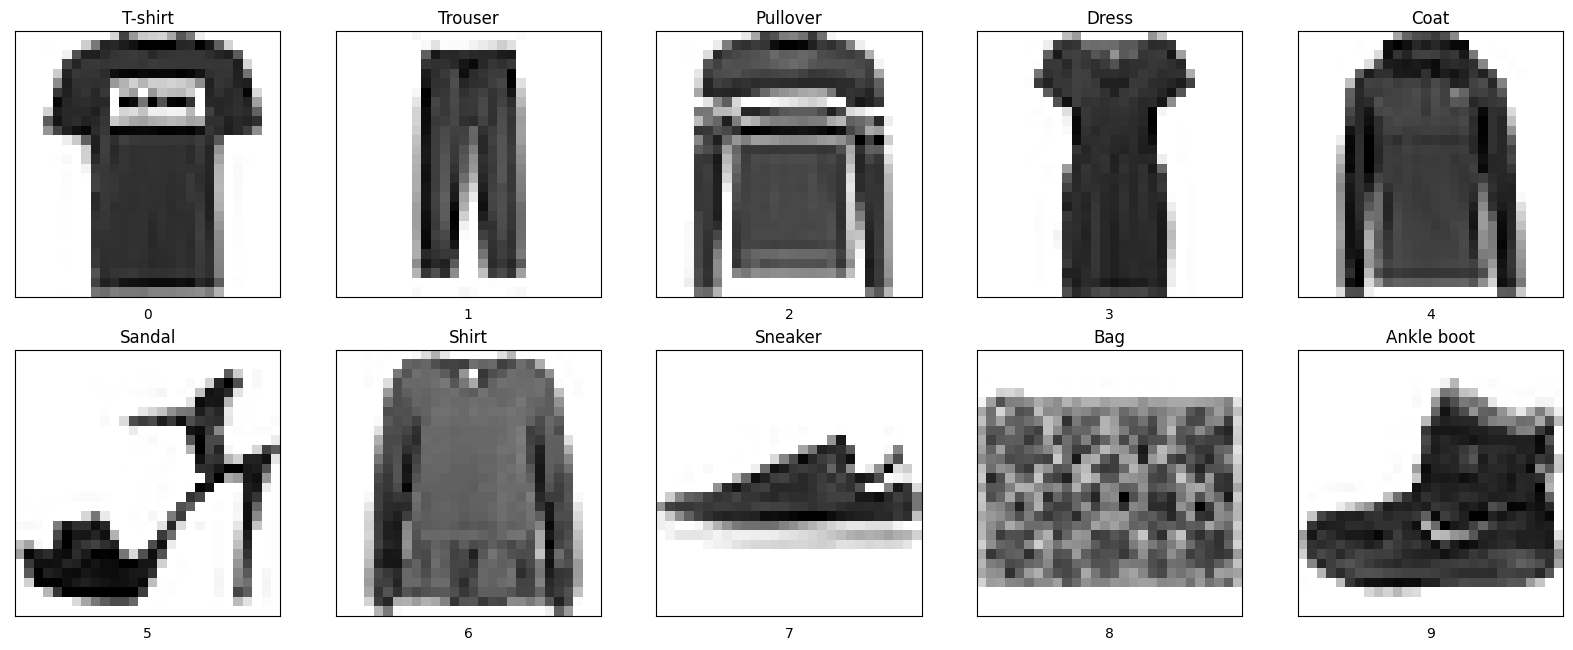

In [8]:
array_of_each_class_position = [1,21,5,20,24,9,18,6,23,0]
# plot all images in array_of_each_class_position
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[i])
    plt.imshow(tf.keras.datasets.fashion_mnist.load_data()[0][0][array_of_each_class_position[i]], cmap=plt.cm.binary)
    plt.xlabel(tf.keras.datasets.fashion_mnist.load_data()[0][1][array_of_each_class_position[i]])
plt.show()

# EDA

## Distribution of Data

In [9]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(pd.DataFrame(y_train, columns=["label"]))

Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%


## Normalizing the data

In [10]:
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

# Info for building models

The Sequential model is a linear stack of layers. It can be first initialized and then we add layers using add method or we can add all layers at init stage. The layers added are as follows:

Conv2D is a 2D Convolutional layer (i.e. spatial convolution over images). The parameters used are:

filters - the number of filters (Kernels) used with this layer; here filters = 32;
kernel_size - the dimmension of the Kernel: (3 x 3);
activation - is the activation function used, in this case relu;
kernel_initializer - the function used for initializing the kernel;
input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28 The input and output of the Conv2D is a 4D tensor.
MaxPooling2D is a Max pooling operation for spatial data. Parameters used here are:

pool_size, in this case (2,2), representing the factors by which to downscale in both directions;

Conv2D with the following parameters:

filters: 64;
kernel_size : (3 x 3);
activation : relu;
MaxPooling2D with parameter:

pool_size : (2,2);
Conv2D with the following parameters:

filters: 128;
kernel_size : (3 x 3);
activation : relu;
Flatten. This layer Flattens the input. Does not affect the batch size. It is used without parameters;

Dense. This layer is a regular fully-connected NN layer. It is used without parameters;

units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
activation - activation function : relu;
Dense. This is the final layer (fully connected). It is used with the parameters:

units: the number of classes (in our case 10);
activation : softmax; for this final layer it is used softmax activation (standard for multiclass classification)
Then we compile the model, specifying as well the following parameters:

In [11]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 1 - Basic CNN (Stupid baseline)

In [12]:
# reshape dataset to have a single channel
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.fit(x_train,y_train , epochs=10)

model.summary()

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 0.4955 - accuracy: 0.8246
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3728 - accuracy: 0.8661
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3371 - accuracy: 0.8763
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3138 - accuracy: 0.8848
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2942 - accuracy: 0.8914
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2809 - accuracy: 0.8966
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2687 - accuracy: 0.9007
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2577 - accuracy: 0.9037
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2473 - accuracy: 0.9069
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.239

# Model 2 - Adding more layers

In [15]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                kernel_initializer='he_normal',
                input_shape=(28,28,1)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
#loop through the optimizers
model_2.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
    

model_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)         

In [16]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('best_model2.hdf5', save_best_only = True)

In [17]:
history = model_2.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Epoch 1/50


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 8s 12ms/step - loss: 0.7787 - accuracy: 0.7071 - val_loss: 0.4842 - val_accuracy: 0.8238
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.4832 - accuracy: 0.8208 - val_loss: 0.3863 - val_accuracy: 0.8580
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.4120 - accuracy: 0.8505 - val_loss: 0.3459 - val_accuracy: 0.8746
Epoch 4/50
235/235 [==============================] - 2s 8ms/step - loss: 0.3663 - accuracy: 0.8656 - val_loss: 0.3049 - val_accuracy: 0.8872
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.3387 - accuracy: 0.8771 - val_loss: 0.2946 - val_accuracy: 0.8904
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.3200 - accuracy: 0.8835 - val_loss: 0.2768 - val_accuracy: 0.8980
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.3068 - accuracy: 0.8877 - val_loss: 0.2794 - val_accuracy: 0.8996
Epoch 8/50
235/

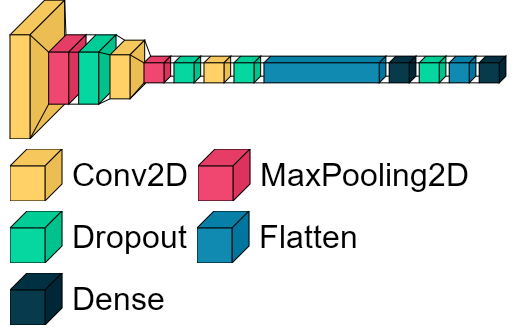

In [18]:
import visualkeras
visualkeras.layered_view(model_2).show()
visualkeras.layered_view(model_2, to_file='output.png')
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model_2, legend=True, font=font)  # font is optional!

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename=f'accuracy-loss_{train_model}')
    

In [21]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [22]:
score = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2264714390039444
Test accuracy: 0.9179999828338623


## Visualising model performance

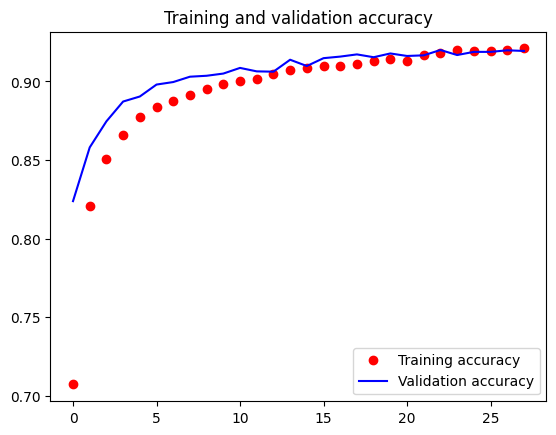

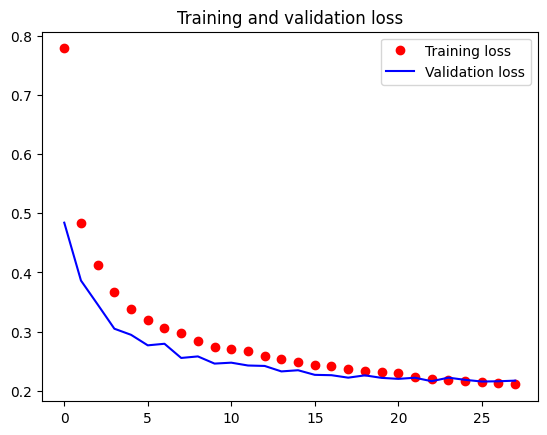

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Showing performance based on predicted values

In [26]:
y_test

array([1, 2, 5, ..., 6, 3, 3], dtype=uint8)

In [27]:
#get the predictions for the test data
predicted_classes = model.predict(x_test)

157/157 [==============================] - 0s 2ms/step


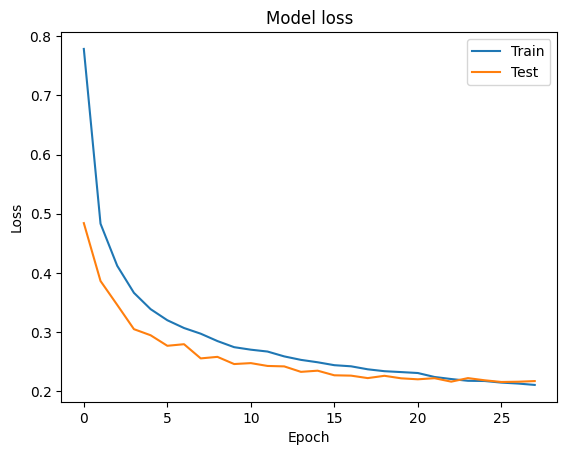

In [28]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()
plot_loss(history.history['loss'], history.history['val_loss'])

In [29]:
#locate index of '1' in each row
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
print(predicted_classes)

[1 2 9 ... 0 3 6]


In [30]:
from sklearn.metrics import classification_report
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(predicted_classes==y_test)[0]
incorrect = np.nonzero(predicted_classes!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.84      0.87      0.85       501
    Item Trouser 1       1.00      0.95      0.97       492
   Item Pullover 2       0.74      0.83      0.78       470
      Item Dress 3       0.86      0.92      0.89       509
       Item Coat 4       0.81      0.77      0.79       499
     Item Sandal 5       0.97      0.95      0.96       517
      Item Shirt 6       0.72      0.62      0.67       471
    Item Sneaker 7       0.92      0.97      0.95       520
        Item Bag 8       0.98      0.98      0.98       520
 Item Ankle Boot 9       0.96      0.93      0.95       501

          accuracy                           0.88      5000
         macro avg       0.88      0.88      0.88      5000
      weighted avg       0.88      0.88      0.88      5000



## Correct predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_31480\1733643227.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



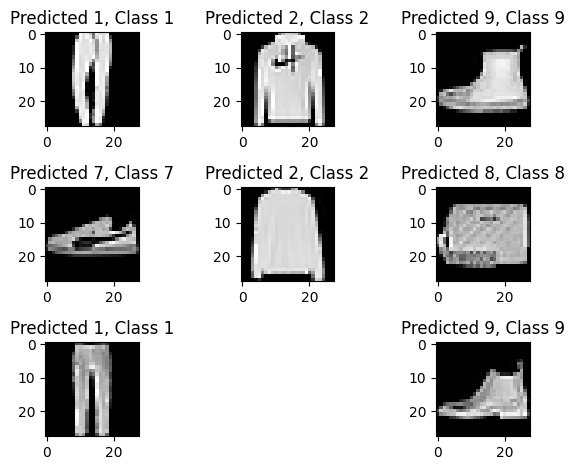

In [31]:
for i, correct_val in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct_val], y_test[correct_val]))
    plt.tight_layout()

## Incorrect predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_31480\3139133992.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



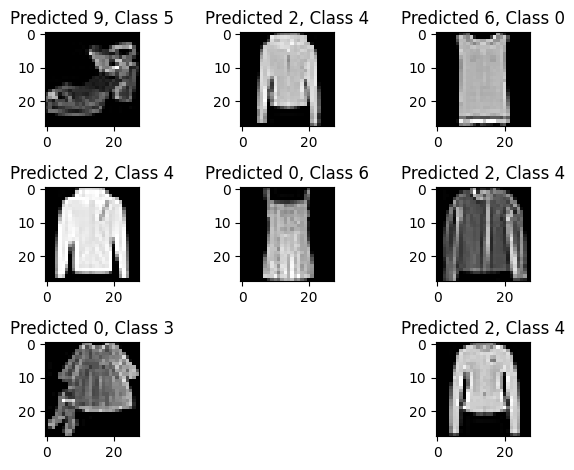

In [32]:
for i, incorrect_val in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect_val], y_test[incorrect_val]))
    plt.tight_layout()

# Tuning Model 2 

Trying out with data augmentation

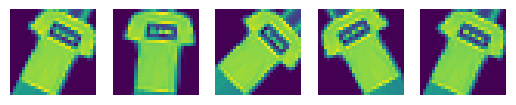

In [33]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,  
    zca_whitening=False,
    rotation_range=50,
    width_shift_range=0.01, 
    height_shift_range=0.01, 
    horizontal_flip=False, 
    vertical_flip=False)

datagen.fit(x_train)
datagen.fit(x_valid)
datagen.fit(x_test)
from matplotlib import pyplot as plt

gen = datagen.flow(x_train[1:2], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

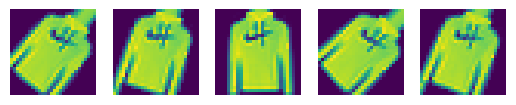

In [34]:
gen_2 = datagen.flow(x_test[1:2], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen_2.next().squeeze())
    plt.plot()
plt.show()

In [35]:
def model_2_create():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
        

    model.summary()
    return model

In [36]:
model_2_data_augmented = model_2_create().fit(x_train, y_train,  
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 64)         

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 4s 12ms/step - loss: 0.8130 - accuracy: 0.6959 - val_loss: 0.5008 - val_accuracy: 0.8146
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.5135 - accuracy: 0.8091 - val_loss: 0.4200 - val_accuracy: 0.8482
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.4376 - accuracy: 0.8405 - val_loss: 0.3653 - val_accuracy: 0.8674
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.3968 - accuracy: 0.8554 - val_loss: 0.3324 - val_accuracy: 0.8786
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.3627 - accuracy: 0.8676 - val_loss: 0.3099 - val_accuracy: 0.8864
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.3439 - accuracy: 0.8739 - val_loss: 0.2978 - val_accuracy: 0.8896
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.3251 - accuracy: 0.8815 - val_loss: 0.2879 - val_accuracy: 0.8936
Epoch 8/50
2

In [37]:
print('Test accuracy:', model_2_data_augmented.model.evaluate(x_test, y_test))

157/157 [==============================] - 1s 4ms/step - loss: 0.2327 - accuracy: 0.9174
Test accuracy: [0.23270797729492188, 0.9174000024795532]


Test loss: 0.23270797729492188
Test accuracy: 0.9174000024795532


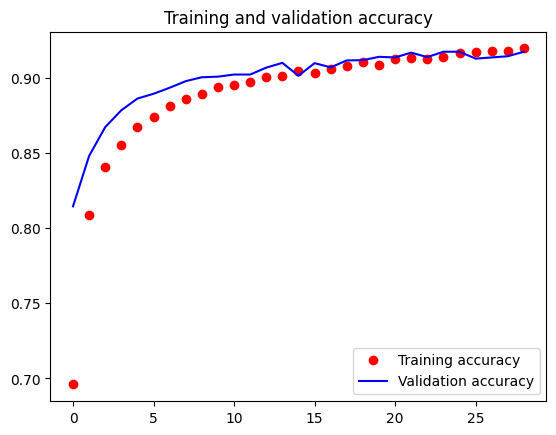

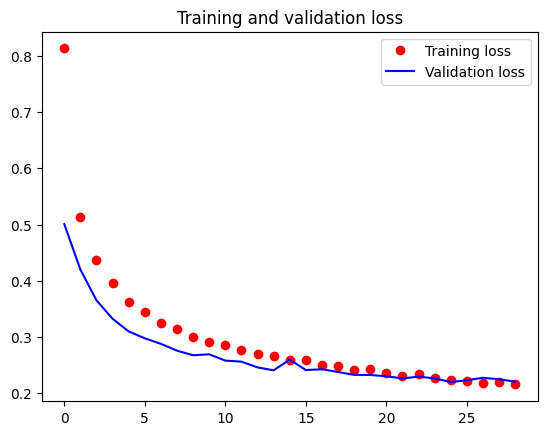

In [38]:
score = model_2_data_augmented.model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
accuracy = model_2_data_augmented.history['accuracy']
val_accuracy = model_2_data_augmented.history['val_accuracy']
loss = model_2_data_augmented.history['loss']
val_loss = model_2_data_augmented.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
plot_accuracy_and_loss(model_2_data_augmented)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [45]:
predicted_classes = model_2_data_augmented.model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
print(predicted_classes)

157/157 [==============================] - 1s 6ms/step
[8 1 8 ... 0 5 4]


In [46]:
from sklearn.metrics import classification_report
#outputing as classifcation matrix to see the accuracy of each class

labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(predicted_classes==y_test)[0]
incorrect = np.nonzero(predicted_classes!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.70      0.94      0.80       507
    Item Trouser 1       1.00      0.97      0.98       506
   Item Pullover 2       0.88      0.86      0.87       484
      Item Dress 3       0.94      0.91      0.92       514
       Item Coat 4       0.88      0.84      0.86       469
     Item Sandal 5       0.98      0.97      0.98       508
      Item Shirt 6       0.83      0.64      0.72       500
    Item Sneaker 7       0.95      0.97      0.96       508
        Item Bag 8       0.99      0.98      0.98       504
 Item Ankle Boot 9       0.98      0.96      0.97       500

          accuracy                           0.91      5000
         macro avg       0.91      0.90      0.90      5000
      weighted avg       0.91      0.91      0.91      5000



Trying out with batch normalization/dropout

In [41]:
#Get back original x_train,x_test,x_valid
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

(60000, 28, 28, 1)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


Trying out regularization techniques to improve the model

Trying out different optimizers and learning rates

In [42]:
def tune_model_2(hp):
    optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
    activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    for optimizer in optimizers:
        model.compile(optimizer=optimizer(hp.Choice('learning_rate',values=[1e-2,1e-4]),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy']))


    model.summary()
    return model

In [43]:
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
        tune_model_2,
        objective='val_accuracy',
        max_trials=5,
        directory="model_2_tune")
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train,y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters


C:\Users\Xavier\AppData\Local\Temp\ipykernel_31480\3646309144.py:2: DeprecationWarning:

`import kerastuner` is deprecated, please use `import keras_tuner`.



TypeError: 'str' object is not callable

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('accuracy')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

NameError: name 'tuner' is not defined

# Final Model 2 

# Trying out Model 3 - VGG